In [358]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import networkx as nx
import torch
tt =  torch.tensor
from torch.distributions import TransformedDistribution
import pyro
from pyro.distributions import (
    Bernoulli,
    Beta,
    Binomial,
    Categorical,
    Exponential,
    LKJCorrCholesky,
    LKJCholesky,
    LogNormal,
    MultivariateNormal,
    Normal,
    Poisson,
)

import scipy.stats as st
from pyro.distributions.transforms import AffineTransform
from pyro.ops.stats import hpdi, quantile, waic
from pyro.infer import Predictive
import arviz as az
import seaborn as sns

from utils import train_nuts, unnest_samples, traceplot

In [359]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Tue Oct 01 2024

Python implementation: CPython
Python version       : 3.9.19
IPython version      : 8.18.1

numpy     : 1.26.4
matplotlib: 3.9.0
sys       : 3.9.19 (main, May  6 2024, 19:43:03) 
[GCC 11.2.0]
pyro      : 1.9.1
arviz     : 0.17.1
networkx  : 3.1
torch     : 2.3.0
seaborn   : 0.12.2
pandas    : 2.2.2
scipy     : 1.12.0

Watermark: 2.4.3



### Code 15.8 - 15.15
As we saw in the previous section, we can easily create better estimates of observed variables by representing them as distributions to be inferred. Incredibly, we can also do the same thing with data that is missing entirely! This is much more efficient than simply dropping examples with missing values because now we can use the full data. However, it is not so simple, as we saw with the measurement error examples. There could be hidden factors that correlate with the missing values that can confound our measurements! Let us examine four examples:

In [360]:
def graph_base():
    G = nx.DiGraph()
    G.add_nodes_from([
        ("S", dict(pos=(0, 1), color="white")),
        ("H", dict(pos=(1, 1), color="#CCCCCC")),
        ("Hm", dict(pos=(1, 0), color="white", label=r"$H^*$")),
        ("D", dict(pos=(0, 0), color="white")),
    ])
    G.add_edges_from([("S","H"), ("H","Hm"), ("D","Hm")])
    return G

def plot_graph(G):
    c = nx.get_node_attributes(G, "color").values()
    pos = nx.get_node_attributes(G, "pos")
    labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
    return nx.draw_networkx(G, pos, labels=labels, node_color=c, node_size=800)

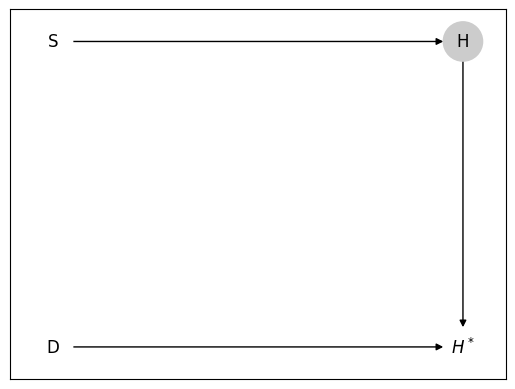

In [361]:
# first example
G = graph_base()
plot_graph(G)

In the above example, we have some students studying for their homework. The results of their homework $H$ are determined by the amount of studying they do $S$. However, each of these students has a dog, and sometimes the dog will eat their homework $D$. The effect of $D$ on $H$ is to produce some homework with potentially missing values $H^*$. In this case, the dogs each homework _completely at random_ (that is a technical term for the type of missingness). If we want to determine the relationship between $S$ and $H$, then there is no problem because $H \perp\!\!\perp D$, as long as we don't condition on $H^*$ (i.e. we throw away all the missing data points). It's too bad we have to throw them away, but it does not bias our results.

In [362]:
# sample homework from students
N = 200
S = Normal(0., 1.).sample([N])
# HW graded on 10 point scale
H = Binomial(10, torch.sigmoid(S)).sample()

In [363]:
# introduce dogs eating homework
D = Bernoulli(0.5).sample([N])
Hm = H.clone()
Hm[D==1] = np.nan
Hm

tensor([ 4., nan, 10., nan, nan, nan, nan, nan,  3., nan,  7., nan, nan,  4.,
        10.,  3., nan, nan,  9., nan,  9.,  6.,  2., nan,  6.,  0., nan,  7.,
        nan,  8.,  6.,  5., nan, nan,  5.,  4., nan, nan, nan, nan, nan, nan,
        nan,  4.,  7., nan, nan, nan,  9., nan,  2.,  8., nan,  8., nan, nan,
        nan, nan,  5., nan, nan, nan,  9., nan,  9.,  3., nan,  0., nan,  2.,
         2., nan, nan,  6., nan,  3., nan, nan, nan, nan, nan,  0., nan, nan,
        nan, nan,  4., nan, nan,  6., nan,  6., nan,  6., nan,  2., nan, 10.,
        nan, nan, 10.,  6.,  4.,  1., nan,  2., nan, nan,  1.,  1.,  8.,  8.,
         6.,  6.,  4., nan,  6., nan, nan, 10., nan,  5.,  1.,  7., nan, nan,
        nan,  9., nan, nan,  0.,  5., nan,  6.,  4.,  9.,  2., nan, nan, nan,
         0., nan, nan, nan,  6., nan, nan, nan,  1., nan,  8.,  6., nan, nan,
         3., nan, nan, nan,  5., nan,  4.,  1., nan, 10., nan, nan, nan,  6.,
        nan,  5., nan,  5.,  4., nan, nan, nan,  1.,  4., nan,  

Can we still see the positive association of studying on homework even though we are missing half the data? Yes:

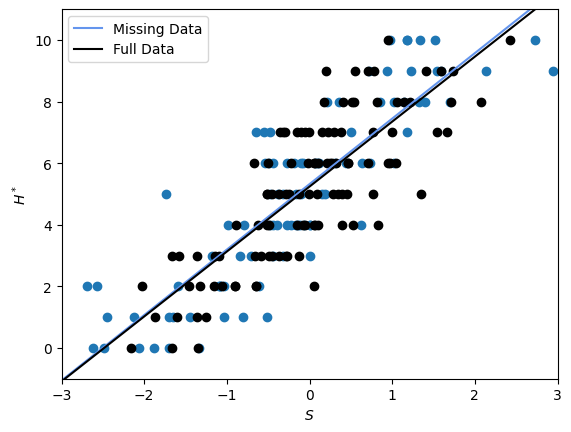

In [364]:
mask = ~torch.isnan(Hm)
plt.scatter(S[mask], Hm[mask])
plt.scatter(S[torch.where(~mask)], H[torch.where(~mask)], color="k")

m, b, r, _, _ = st.linregress(S[mask], Hm[mask])
x = np.linspace(-3, 3, 100)
y = m*x + b
plt.plot(x, y, color="cornflowerblue", label="Missing Data")


m, b, r, _, _ = st.linregress(S, H)
y = m*x + b
plt.plot(x, y, color="k", label="Full Data")

S[torch.where(~mask)], H[torch.where(~mask)]
plt.xlabel(r"$S$")
plt.ylabel(r"$H^*$")
plt.xlim(left=-3, right=3)
plt.ylim(bottom=-1, top=11)
plt.legend()
plt.show()

Now let's consider the next case, where $S$ influences $D$. Perhaps in this scenario, students who study more often don't play with their dogs quite as much, and so the dogs take revenge by eating their homework.

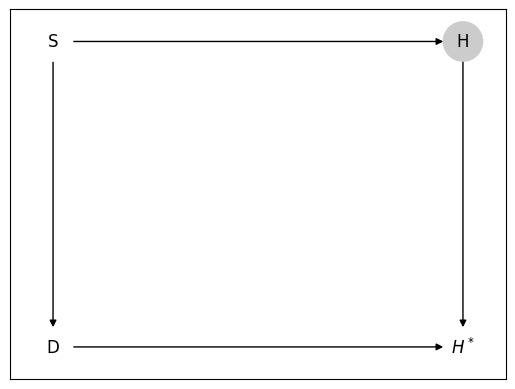

In [365]:
G = graph_base()
G.add_edge("S", "D")
plot_graph(G)

This opens up a non-causal path through $S \rightarrow D \rightarrow H^* \leftarrow H$ that can confound the relationship $S \rightarrow H$. But it isn't all bad. We can still infer the relationship at low $S$. But now we have no idea what happens when $S$ is large. We also do not observe any high marks on the homework, so perhaps we think students have not been studying! How much information we can glean out of the data now depends on the nature of the functional relationship between the variables.

In [366]:
# dogs eat homework if S>0
D = torch.zeros(N)
D[S>0] = 1.
Hm = H.clone()
Hm[D==1.] = np.nan

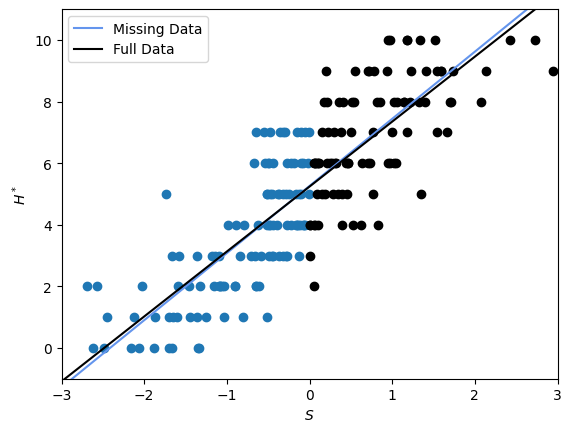

In [367]:
mask = ~torch.isnan(Hm)
plt.scatter(S[mask], Hm[mask])
plt.scatter(S[~mask], H[~mask], color="k")

m, b, r, _, _ = st.linregress(S[mask], Hm[mask])
y = m*x + b
plt.plot(x, y, color="cornflowerblue", label="Missing Data")

m, b, r, _, _ = st.linregress(S, H)
y = m*x + b
plt.plot(x, y, color="k", label="Full Data")

plt.xlabel(r"$S$")
plt.ylabel(r"$H^*$")
plt.xlim(left=-3, right=3)
plt.ylim(bottom=-1, top=11)
plt.legend()
plt.show()

The next scenario is more difficult. In this one, there is another outside factor $X$ that influences both $D$ and $H$. Perhaps it is the presence of noise in the student's home. Lots of noise makes it difficult to study, and also causes dogs to misbehave more frequently.

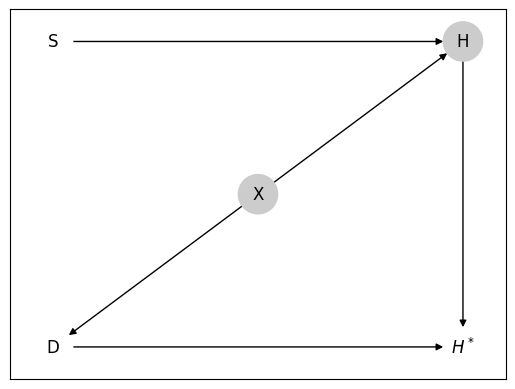

In [368]:
G = graph_base()
G.add_node("X", pos=(0.5, 0.5), color="#CCCCCC")
G.add_edges_from([("X", "H"), ("X", "D")])
plot_graph(G)

In [369]:
N = 200
X = Normal(0., 1.).sample([N])
S = Normal(0., 1.).sample([N])
H = Binomial(10, torch.sigmoid(2+S-2*X)).sample()
D = torch.zeros(N)
D[X>1] = 1.
Hm = H.clone()
Hm[D==1.] = np.nan

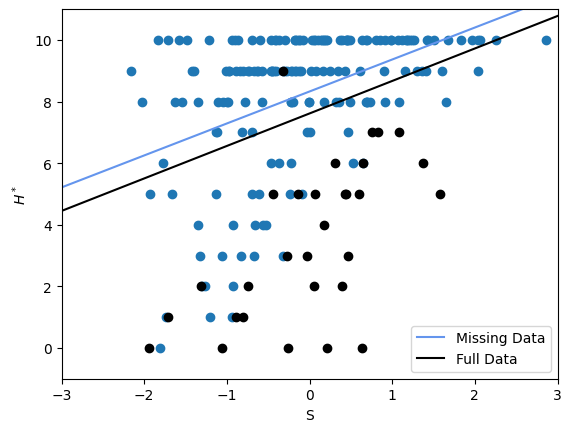

In [370]:
mask = ~torch.isnan(Hm)
plt.scatter(S[mask], Hm[mask])
plt.scatter(S[~mask], H[~mask],color="k")

m, b, r, _, _ = st.linregress(S[mask], Hm[mask])
y = m*x + b
plt.plot(x, y, color="cornflowerblue", label="Missing Data")

m, b, r, _, _ = st.linregress(S, H)
y = m*x + b
plt.plot(x, y, color="k", label="Full Data")

plt.xlabel("S")
plt.ylabel(r"$H^*$")
plt.xlim(left=-3, right=3)
plt.ylim(bottom=-1, top=11)
plt.legend()
plt.show()

In this scenario, it now appears that the majority of students get high marks, and so we might think that everyone did much better than they actually did. When regressing $H^*$ on $S$, we now have a new non-causal path $H \leftarrow X \rightarrow D \leftarrow H^*$ to deal with that can confound our inference of $H$. Let's run an actual inference just to observe this effect. First, we will just regress $H$ on $S$ (without accounting for $X$)

In [371]:
data = {"H": H, "S": S}

In [372]:
def model_m15_3(data, training=True):
    a = pyro.sample("a", Normal(0., 1.))
    bS = pyro.sample("bS", Normal(0., 0.5))
    p = torch.sigmoid(a + bS*data["S"])
    pyro.sample("H", Binomial(10, p), obs=data["H"])

In [373]:
m15_3 = train_nuts(model_m15_3, data, 1500, 4000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 5500/5500 [00:08, 647.13it/s, step size=8.05e-01, acc. prob=0.915]


In [374]:
m15_3.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.25      0.06      1.25      1.15      1.34   2633.94      1.00
        bS      0.62      0.06      0.62      0.52      0.71   2537.44      1.00

Number of divergences: 0


We can see that the estimate of $\beta_S$ is way off; it should be 1.0. But this has nothing to do with missing data because we observed $H$ before the dogs got at it. This is a case of _omitted variable bias_, where not conditioning on $X$ is what has caused this slip-up. Now what happens when we observe $H^*$, after the dogs have got at it? Do you think the inference will get worse or better?

In [375]:
data = {"H": H[D==0.], "S": S[D==0.]}

In [376]:
m15_4 = train_nuts(model_m15_3, data, 1500, 4000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 5500/5500 [00:09, 590.78it/s, step size=6.50e-01, acc. prob=0.928]


In [377]:
m15_4.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      1.80      0.08      1.80      1.67      1.93   1689.07      1.00
        bS      0.82      0.08      0.82      0.70      0.96   1610.77      1.00

Number of divergences: 0


Turns out it actually gets a little better! Since $X$ influences both $H$ and $D$, the missing homeworks tend to come from noisy houses, which tend to produce lower grades on homeworks. So by dropping the missing homeworks, we actually end up dropping examples that were influenced by $X$, partially alleviating the omitted variable bias. Note that this is not always the case. If instead $D=1$ when $|X|<1$, then we end up missing out on cases where $X$ has the least influence on $H$, and this biases the result even more.

Finally, we consider the fourth case, where $H \rightarrow D$. In this case, dogs prefer to eat bad homework (or perhaps the students just say they do?). There is nothing we can do to block the non-causal path $S \rightarrow H \rightarrow D \rightarrow H^*$. So unless we know the mechanism that produces the missingness, reconstructing the relationship between $S$ and $H$ is pretty hard, and even if you do know the mechanism, it might be impossible.

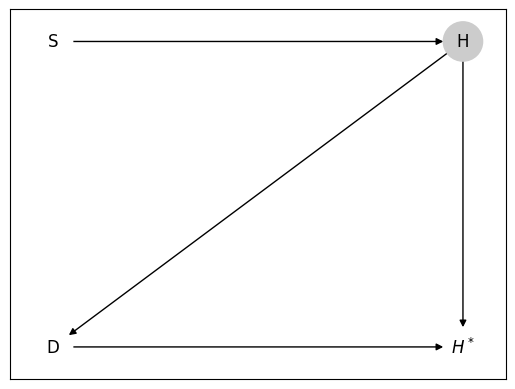

In [378]:
G = graph_base()
G.add_edge("H", "D")
plot_graph(G)

In [379]:
N = 100
S = Normal(0., 1.).sample([N])
H = Binomial(10, torch.sigmoid(S)).sample()
D = torch.zeros(N)
D[H<5] = 1.
Hm = H.clone()
Hm[D==1.] = np.nan

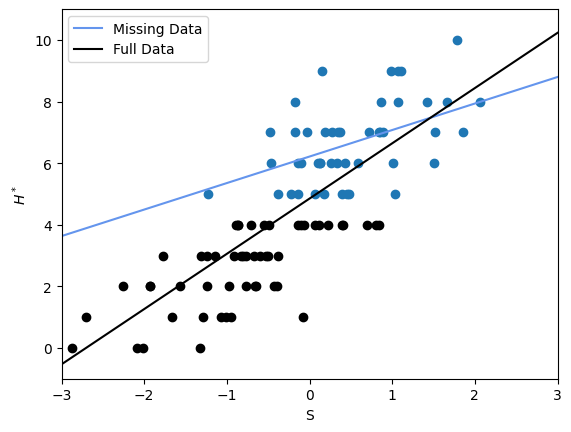

In [380]:
mask = ~torch.isnan(Hm)
plt.scatter(S[mask], Hm[mask])
plt.scatter(S[~mask], H[~mask],color="k")

m, b, r, _, _ = st.linregress(S[mask], Hm[mask])
y = m*x + b
plt.plot(x, y, color="cornflowerblue", label="Missing Data")

m, b, r, _, _ = st.linregress(S, H)
y = m*x + b
plt.plot(x, y, color="k", label="Full Data")

plt.xlabel("S")
plt.ylabel(r"$H^*$")
plt.xlim(left=-3, right=3)
plt.ylim(bottom=-1, top=11)
plt.legend()
plt.show()

In [381]:
data = {"H": H[D==0.], "S": S[D==0.]}

In [382]:
m15_5 = train_nuts(model_m15_3, data, 1500, 4000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 5500/5500 [00:08, 615.00it/s, step size=6.38e-01, acc. prob=0.922]


In [383]:
m15_5.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.50      0.12      0.50      0.30      0.68   1619.40      1.00
        bS      0.40      0.13      0.39      0.19      0.62   1724.38      1.00

Number of divergences: 0


The estimate doesn't actually seem _too_ bad, but we are just lucky that the relationship here is linear and extrapolates fairly well. Other relationships might not be so forgiving.

### Code 15.16 - 15.23
Now we will explore how to include missing values in our inferences, in the context of the primates data from an earlier chapter (the one where we explored the relationship between body mass $M$, brain size $B$, and milk energy $K$). If we recall, the basic DAG was

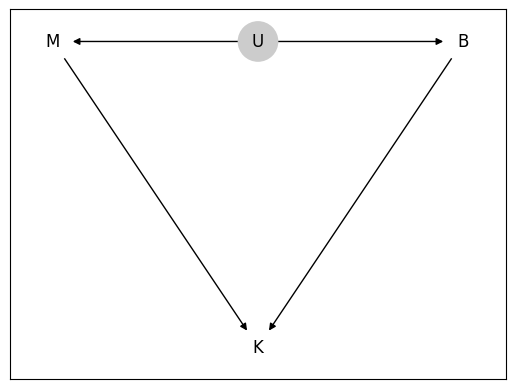

In [384]:
def graph_base():
    G = nx.DiGraph()
    G.add_nodes_from([
        ("M", dict(pos=(0, 1), color="white")),
        ("U", dict(pos=(1, 1), color="#CCCCCC")),
        ("B", dict(pos=(2, 1), color="white")),
        ("K", dict(pos=(1, 0), color="white")),
    ])
    G.add_edges_from([("U","M"), ("U","B"), ("M","K"), ("B","K")])
    return G

G = graph_base()
plot_graph(G)

But in our previous analysis, there were multiple `NaN` values of $B$. We simply dropped these so we could perform a _complete case analysis_, but we know that that is only justified in certain scenarios. Let's lay out three different causal graphs that could explain the missingness:

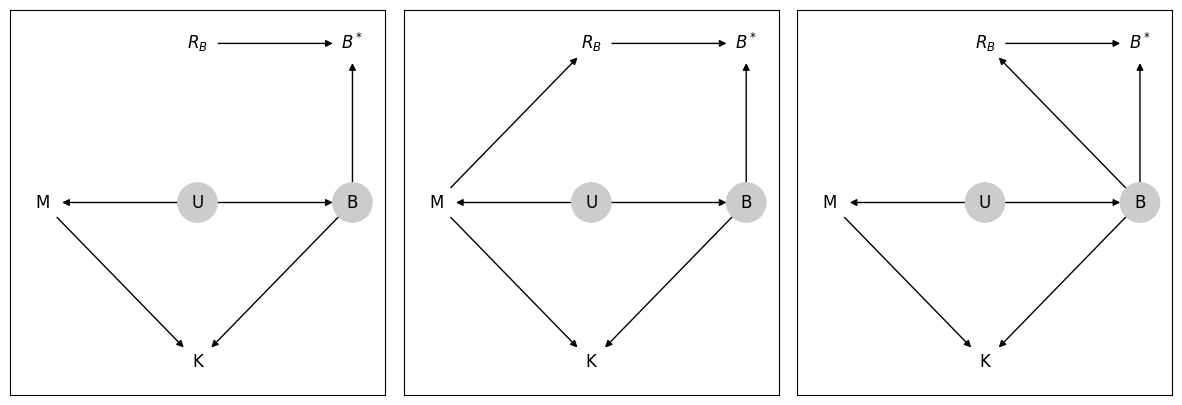

In [385]:
def graph_base_noisy():
    G = graph_base()
    G.nodes["B"]["color"] = "#CCCCCC"
    G.add_node("RB", pos=(1, 2), color="white", label=r"$R_B$")
    G.add_node("B*", pos=(2, 2), color="white", label=r"$B^*$")
    G.add_edges_from([("RB","B*"), ("B","B*")])
    return G

fig, axes = plt.subplots(ncols=3, figsize=(15, 5))
plt.sca(axes[0])
G1 = graph_base_noisy()
plot_graph(G1)
plt.sca(axes[1])
G2 = graph_base_noisy()
G2.add_edge("M", "RB")
plot_graph(G2)
plt.sca(axes[2])
G3 = graph_base_noisy()
G3.add_edge("B", "RB")
plot_graph(G3)
plt.subplots_adjust(wspace=0.05)
plt.show()

In the left DAG, $R_B$ is not influenced by anything, so the complete case analysis does not bias our results at all, and we are free to drop missing values. In the middle case, $R_B$ is influenced by $M$ (perhaps larger primates are studied more often), which opens up a non-causal path through $B^* \leftarrow R_B \leftarrow M \rightarrow K$, but we can close this off by conditioning on $M$. The right case is the trickiest. $R_B$ is influenced by $B$ itself (perhaps humans are more likely to study primates with large brains because we have large brains ourselves). There is really nothing we can do about this case to eliminate the bias from the path $B^* \leftarrow R_B \leftarrow B \rightarrow K$

So the only reasonable way to figure out what the influence of $B$ on $K$ is, is to impute the missing values of $B$ (whether that is to use our data more efficiently as in cases 1/2, or to try and eliminate some bias as in case 3). Our plan is to simply replace missing values of $B$ with distributions, and learn the posterior distribution that best fits with the model.

$$\begin{align*}
K_i &\sim \text{Normal}(\mu_i, \sigma) \\
\mu_i &= \alpha + \beta_B B_i + \beta_M \log M_i \\
B_i &\sim \text{Normal}(\nu, \sigma_B) \\
\alpha, \beta_B, \beta_M &\sim \text{Normal}(0, 0.5) \\
\sigma, \sigma_B &\sim \text{Exponential}(1) \\
\nu &\sim \text{Normal}(0.5, 1)
\end{align*}$$

In the above model, it is understood that only the $B_i$ which are missing are sampled from this distribution; the ones that not missing are observed with likelihood described by this distribution.

In [386]:
milk_df = pd.read_csv("data/milk.csv", sep=";")
milk_df.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


In [387]:
def standardize(x):
    nan = torch.isnan(x)
    return (x - x[~nan].mean())/x[~nan].std()

df = milk_df
data = {
    "M": standardize(tt(df["mass"].values).double().log()),
    "B*": standardize(tt(df["neocortex.perc"].values).double()),
    "K": standardize(tt(df["kcal.per.g"].values).double()),
    "nan": tt(df["neocortex.perc"].isna().values).bool(),
    "nan_idx": tt(np.arange(len(df))[df["neocortex.perc"].isna()]).long(),
    "n_missing": df["neocortex.perc"].isna().sum(),
}

In [388]:
data

{'M': tensor([-0.4558, -0.4150, -0.3072, -0.5650, -0.3875,  0.1274,  0.1408, -0.3072,
         -1.0508, -1.0763, -2.0978, -1.2938, -1.5202, -1.1500, -0.1164, -0.5910,
          0.3036, -0.1568,  0.3711,  0.6288,  0.3445,  0.1408,  0.5479,  1.2527,
          1.7274,  1.8494,  1.3342,  1.2120,  1.5104], dtype=torch.float64),
 'B*': tensor([-2.0802,     nan,     nan,     nan,     nan, -0.5086, -0.5086,  0.0107,
             nan,  0.2135, -1.4620, -0.9861, -1.2157,     nan,     nan,  0.4011,
             nan,  0.4748,     nan,  0.9758,     nan, -0.0077,     nan,  0.6172,
          0.8418,     nan,  0.4464,  1.4617,  1.3260], dtype=torch.float64),
 'K': tensor([-0.9400, -0.8161, -1.1259, -1.0020, -0.2585, -1.0640, -0.5063,  1.5382,
          1.6622,  1.7241,  0.9806, -1.1259,  0.4230,  0.4230,  0.5469,  0.2371,
          0.4850,  2.0339,  0.9187,  1.2285, -1.0020, -0.1346, -0.8161, -0.6303,
         -0.9400, -0.6922, -1.0020, -0.5683,  0.4230], dtype=torch.float64),
 'nan': tensor([False,  

In [389]:
def model_m15_6(data, training=False):
    a = pyro.sample("α", Normal(0., 0.5))
    bB = pyro.sample("βB", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    σ = pyro.sample("σ", Exponential(1.))
    σB = pyro.sample("σB", Exponential(1.))
    ν = pyro.sample("ν", Normal(0.5, 1.))
    B, M, nan = [data[k] for k in ("B*", "M", "nan")]
    B_impute = pyro.sample("B_impute", Normal(ν, σB).expand([data["n_missing"]])).double()
    B = torch.index_copy(B, 0, data["nan_idx"], B_impute)
    if training:
        pyro.sample("B*", Normal(ν, σB).mask(~nan), obs=B)
    μ = a + bB*B + bM*M
    if training:
        pyro.sample("K", Normal(μ, σ), obs=data["K"])
    else:
        return pyro.sample("K", Normal(μ, σ))

In [390]:
m15_6 = train_nuts(model_m15_6, data, 500, 1000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/1500 [00:00, ?it/s]/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/pyro/distributions/torch_distribution.py:322: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if mask.shape != batch_shape:
Sample: 100%|██████████| 1500/1500 [00:10, 145.79it/s, step size=4.50e-01, acc. prob=0.876]


In [391]:
m15_6.summary()


                  mean       std    median      5.0%     95.0%     n_eff     r_hat
 B_impute[0]     -0.52      0.94     -0.56     -2.06      0.96    822.90      1.00
 B_impute[1]     -0.62      0.90     -0.72     -2.06      0.89    723.02      1.00
 B_impute[2]     -0.64      0.97     -0.65     -2.14      0.96    667.89      1.00
 B_impute[3]     -0.22      0.93     -0.26     -1.72      1.32   1180.29      1.00
 B_impute[4]      0.49      0.94      0.49     -0.93      2.07   1360.99      1.00
 B_impute[5]     -0.10      0.86     -0.14     -1.51      1.26   1238.66      1.00
 B_impute[6]      0.23      0.83      0.25     -1.12      1.65    982.81      1.00
 B_impute[7]      0.29      0.88      0.26     -0.98      1.83   1125.28      1.00
 B_impute[8]      0.51      0.92      0.52     -0.88      2.01   1043.37      1.00
 B_impute[9]     -0.41      0.95     -0.41     -1.94      1.09   1160.16      1.00
B_impute[10]     -0.28      0.91     -0.25     -1.75      1.15   1088.42      1.00
B_i

We can see that there are now 12 `B` parameters that are the imputed distributions. Let's do a quick comparison where we simply drop the missing values:

In [392]:
def model_m15_6x(data, training=False):
    a = pyro.sample("α", Normal(0., 0.5))
    bB = pyro.sample("βB", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    σ = pyro.sample("σ", Exponential(1.))
#     σB = pyro.sample("σB", Exponential(1.))
#     ν = pyro.sample("ν", Normal(0.5, 1.))
    B, M, nan = [data[k] for k in ("B*", "M", "nan")]
#     B_impute = pyro.sample("B", Normal(ν, σB).expand([data["n_missing"]])).double()
#     B = torch.index_copy(B, 0, data["nan_idx"], B_impute)
#     if training:
#         pyro.sample("B*", Normal(ν, σB).mask(~nan), obs=B)
    μ = a + bB*B[~nan] + bM*M[~nan]
    if training:
        pyro.sample("K", Normal(μ, σ), obs=data["K"][~nan])
    else:
        return pyro.sample("K", Normal(μ, σ))

In [393]:
m15_6x = train_nuts(model_m15_6x, data, 500, 1000)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Sample: 100%|██████████| 1500/1500 [00:04, 325.95it/s, step size=4.51e-01, acc. prob=0.937]


In [394]:
m15_6x.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         α      0.11      0.20      0.11     -0.25      0.40    796.76      1.00
        βB      0.60      0.28      0.61      0.13      1.06    455.50      1.00
        βM     -0.64      0.26     -0.64     -1.07     -0.24    423.21      1.00
         σ      0.88      0.18      0.85      0.59      1.14    487.23      1.00

Number of divergences: 0


Let's compare the inferences of the imputed vs complete case models. We can see that the inferences are similar, but that the imputed model has tighter posterior distributions than the complete case model. This is because we are using _all_ the data available, rather than just a subset.

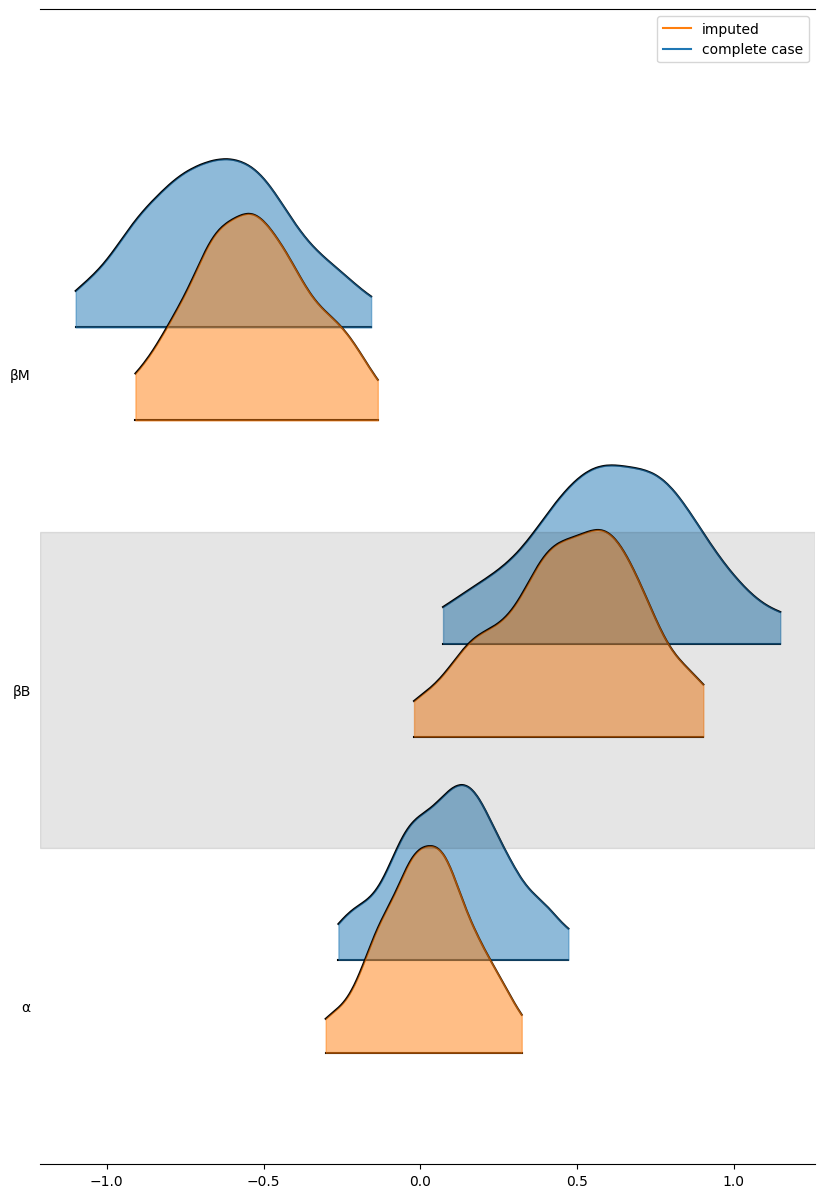

In [395]:
sites = ["α", "βB", "βM"]
fig, ax = plt.subplots(figsize=(10, 15))
s1 = {k: v[None,...] for k, v in m15_6.get_samples().items() if k in sites}
s2 = {k: v[None,...] for k, v in m15_6x.get_samples().items() if k in sites}
az.plot_forest(
    data=[s2, s1],
    kind="ridgeplot",
    model_names=["complete case", "imputed"],
    ridgeplot_overlap=5,
    ridgeplot_alpha=0.5,
    ax=ax)
plt.show()

Let's visualize the imputed data in relation to the non-missing data. We can see that the imputed data sorta tracks the regression line of $B$ vs $K$, but there is almost no correlation in the plot of $M$ vs. $B$, even though the non-imputed data shows a clear trend.

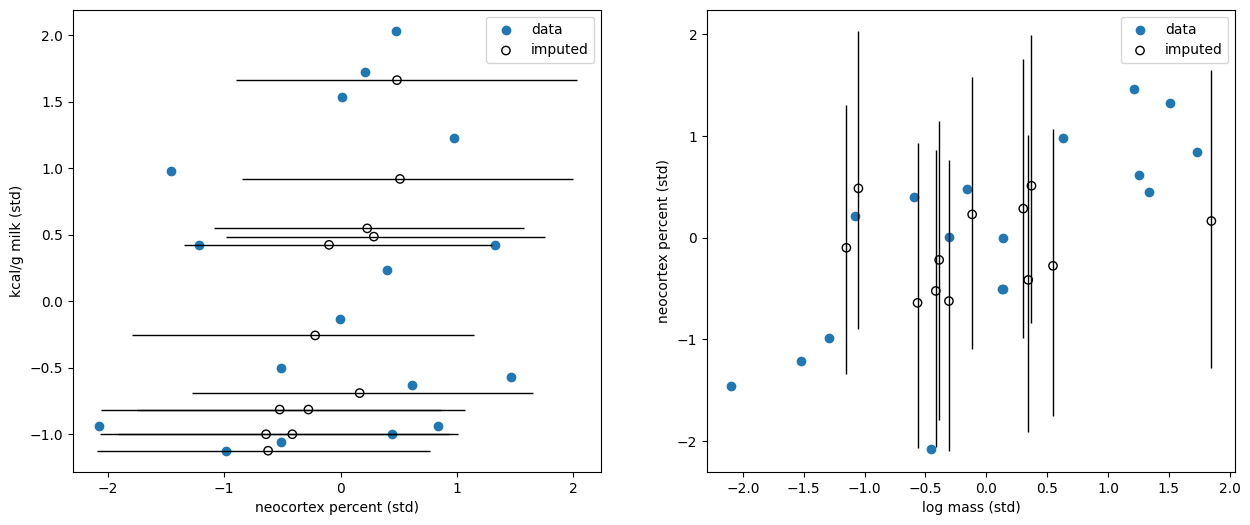

In [396]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
nan = data["nan"]
s = m15_6.get_samples()
# B vs K
plt.sca(axes[0])
x = data["B*"][~nan]
y = data["K"][~nan]
plt.scatter(x, y, label="data")
x = s["B_impute"].mean(dim=0)
y = data["K"][nan]
xerr = (hpdi(s["B_impute"], 0.89) - x[None,:]).abs()
plt.errorbar(x, y, fmt="none", xerr=xerr, color="black", linewidth=1)
plt.scatter(x, y, facecolor="none", edgecolor="black", label="imputed")
plt.xlabel("neocortex percent (std)")
plt.ylabel("kcal/g milk (std)")
plt.legend()
# M vs B
plt.sca(axes[1])
x = data["M"][~nan]
y = data["B*"][~nan]
plt.scatter(x, y, label="data")
x = data["M"][nan]
y = s["B_impute"].mean(dim=0)
yerr = (hpdi(s["B_impute"], 0.89) - y[None,:]).abs()
plt.errorbar(x, y, fmt="none", yerr=yerr, color="black", linewidth=1)
plt.scatter(x, y, facecolor="none", edgecolor="black", label="imputed")
plt.xlabel("log mass (std)")
plt.ylabel("neocortex percent (std)")
plt.legend()
plt.show()

$M$ and $B$ are obviously correlated through the unobserved factor $U$ from our DAG. We did not account for this in our model, and this is what's causing the posterior to suck so bad. We can rectify this by using a multivariate prior that mixes $M$ and $B$ together. So instead of the $B_i \sim \text{Normal}(\nu, \sigma_B)$ we had before, we will now use

$$\begin{align*}
(M_i, B_i) &\sim \text{Normal}((\mu_M, \mu_B), \boldsymbol{S}) \\
\mu_B, \mu_M &\sim \text{Normal}(0, 0.5) \\
S &= \Sigma_{BM} R_{BM} \\
R_{BM} &\sim \text{LKJ}(2, 2) \\
\Sigma_{BM} &\sim \text{Exponential}(1)
\end{align*}$$

In [397]:
df = milk_df
data = {
    "M": standardize(tt(df["mass"].values).double().log()),
    "B*": standardize(tt(df["neocortex.perc"].values).double()),
    "K": standardize(tt(df["kcal.per.g"].values).double()),
    "nan": tt(df["neocortex.perc"].isna().values).bool(),
    "nan_idx": tt(np.arange(len(df))[df["neocortex.perc"].isna()]).long(),
    "n_missing": df["neocortex.perc"].isna().sum(),
    "N": len(df),
}

In [398]:
def model_m15_7(data, training=False):
    # priors
    a = pyro.sample("α", Normal(0., 0.5))
    bB = pyro.sample("βB", Normal(0., 0.5))
    bM = pyro.sample("βM", Normal(0., 0.5))
    σ = pyro.sample("σ", Exponential(1.))
    # draw imputed values of B and combine with observed data
    B_imp = pyro.sample("B", Normal(0., 1.).expand([data["n_missing"]])).double()
    B = torch.index_copy(data["B*"], 0, data["nan_idx"], B_imp)
    # stack B and M together and then sample from multivariate normal
    BM = torch.stack([B, data["M"]], dim=1)
    μBM = pyro.sample("μBM", Normal(0., 0.5).expand([2]))
    ΣBM = pyro.sample("ΣBM", Exponential(1.).expand([2]))
    RBM = pyro.sample("RBM", LKJCholesky(2, tt(2.)))
    SBM = torch.diag(ΣBM) @ RBM # scale tril
    if training:
        pyro.sample("B*", MultivariateNormal(μBM, scale_tril=SBM), obs=BM)
    μ = a + bB*BM[:,0] + bM*BM[:,1]
    if training:
        pyro.sample("K", Normal(μ, σ), obs=data["K"])
    else:
        return pyro.sample("K", Normal(μ, σ))

In [399]:
m15_7 = train_nuts(model_m15_7, data, 500, 1000, jit_compile=False)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': False}


Sample: 100%|██████████| 1500/1500 [00:27, 54.68it/s, step size=4.67e-01, acc. prob=0.881]


In [400]:
m15_7.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      B[0]     -0.40      0.58     -0.41     -1.36      0.49   1060.48      1.00
      B[1]     -0.38      0.55     -0.37     -1.27      0.54    844.81      1.00
      B[2]     -0.48      0.57     -0.49     -1.47      0.40    942.39      1.00
      B[3]     -0.25      0.53     -0.25     -1.13      0.57    694.71      1.00
      B[4]     -0.13      0.55     -0.14     -0.95      0.83   1082.91      1.00
      B[5]     -0.44      0.54     -0.46     -1.45      0.34    970.73      1.00
      B[6]      0.07      0.54      0.08     -0.82      0.88   1384.68      1.00
      B[7]      0.23      0.54      0.21     -0.62      1.17   1044.77      1.00
      B[8]      0.34      0.55      0.35     -0.52      1.26    999.61      1.00
      B[9]     -0.05      0.57     -0.09     -0.88      0.92   1233.39      1.00
     B[10]      0.07      0.54      0.06     -0.81      0.96   1217.34      1.00
     B[11]      0.66      0

In [401]:
sigma = tt([0.86, 1.01])
L = tt([[1.0, 0.0], [0.61, 0.78]])
#L = torch.diag(sigma)*L
print(L@L.T)
print(torch.diag(sigma)@L@L.T@torch.diag(sigma))

tensor([[1.0000, 0.6100],
        [0.6100, 0.9805]])
tensor([[0.7396, 0.5298],
        [0.5298, 1.0002]])


Now we can see that the plot of $M$ vs $B$ show correlation amongst the imputed data points, as expected. The slopes of $\beta_B$ and $\beta_M$ have not changed much, so the improvement was primarily in the imputation of $B$.

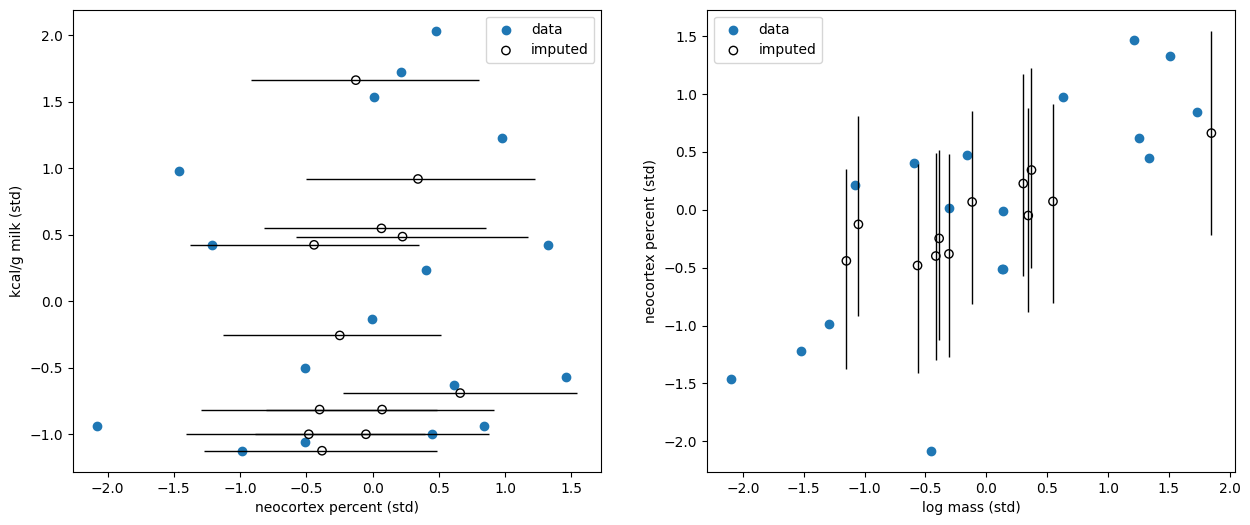

In [402]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 6))
nan = data["nan"]
s = m15_7.get_samples()
# B vs K
plt.sca(axes[0])
x = data["B*"][~nan]
y = data["K"][~nan]
plt.scatter(x, y, label="data")
x = s["B"].mean(dim=0)
y = data["K"][nan]
xerr = (hpdi(s["B"], 0.89) - x[None,:]).abs()
plt.errorbar(x, y, fmt="none", xerr=xerr, color="black", linewidth=1)
plt.scatter(x, y, facecolor="none", edgecolor="black", label="imputed")
plt.xlabel("neocortex percent (std)")
plt.ylabel("kcal/g milk (std)")
plt.legend()
# M vs B
plt.sca(axes[1])
x = data["M"][~nan]
y = data["B*"][~nan]
plt.scatter(x, y, label="data")
x = data["M"][nan]
y = s["B"].mean(dim=0)
yerr = (hpdi(s["B"], 0.89) - y[None,:]).abs()
plt.errorbar(x, y, fmt="none", yerr=yerr, color="black", linewidth=1)
plt.scatter(x, y, facecolor="none", edgecolor="black", label="imputed")
plt.xlabel("log mass (std)")
plt.ylabel("neocortex percent (std)")
plt.legend()
plt.show()

### Code 15.29 - 15.??
In everything we've learned up until now, we have used continuous variables/distributions for all latent sample sites in our models. Yes, we learned about discrete distributions like the Poisson/binomial/Bernoulli, but they were always the final step of our model, where their samples could be observed. Sampling discrete latent variables cause difficulties with HMC because now the likelihood is no longer differentiable. However, we can actually "integrate out" most discrete variables from our models, so that we don't have to sample from them at all! This has the dual advantage of making our sampling computationally easier, and more accurate (because we effectively simultaneously sample from the entire domain of the distribution at once).

We will study this in the context of some cats 🐈. Imagine a neighborhood in which every house contains a songbird. We sample one minute of song from each house and count the notes. But we also notice that some houses have cats, and perhaps this influences how many notes each bird sings. You collect data on the presence/absence of a cat in each house, but in about 20% of cases, you can't determine whether a cat lives there or not. The DAG for this story is

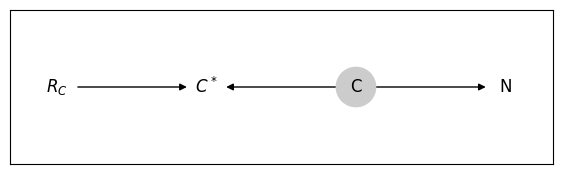

In [403]:
G = nx.DiGraph()
G.add_nodes_from([
    ("RC", dict(pos=(0, 0), color="white", label=r"$R_C$")),
    ("C*", dict(pos=(1, 0), color="white", label=r"$C^*$")),
    ("C", dict(pos=(2, 0), color="#CCCCCC")),
    ("N", dict(pos=(3, 0), color="white"))
])
G.add_edges_from([("RC","C*"),("C","C*"),("C","N")])
plt.figure(figsize=(7, 2))
plot_graph(G)

To make this a fully generative model, we must pick a (statistical) function for each edge in the graph. A simple model for this might be

$$\begin{align*}
N_i &\sim \text{Poisson}(\lambda_i) \\
\lambda_i &= \alpha + \beta C_i \\
C_i &\sim \text{Bernoulli}(k) \\
R_{C,i} &\sim \text{Bernoulli}(r)
\end{align*}$$

where $\alpha>0$ and $\beta>-\alpha$ to enforce positivity of $\lambda$. Here's a simple simulation:

In [404]:
N_houses = 100
alpha = tt(5.)
beta = tt(-3.)
k = tt(0.5)
r = tt(0.2)
cat = Bernoulli(k).sample([N_houses])
notes = Poisson(alpha + beta*cat).sample()
RC = Bernoulli(r).sample([N_houses])
cat_obs = cat.clone()
cat_obs[RC==1] = np.nan

data = {
    "N_houses": N_houses,
    "N_missing": RC.sum().long().item(),
    "N_obs": (1-RC).sum().long().item(),
    "cat": cat_obs,
    "notes": notes,
    "nan": RC.bool(),
    "nan_idx": torch.arange(len(RC))[RC.bool()],
}

The way we "integrate out" the cat variable is by summing over conditional probabilities:

$$ P(N_i) = P(N_i|C=1)P(C=1) + P(N_i|C=0)P(C=0) $$

`pyro` has some built-in techniques known as _automatic enumeration_ to do this kind of thing for us; check out [this tutorial](https://pyro.ai/examples/enumeration.html) for more information. One special trick is the use of the `pyro.plate` context manager. This declares certain tensor dimensions conditionally independent, allows automatic broadcasting, and also allows you to think of your model in terms of a special diagram called [plate notation](https://en.wikipedia.org/wiki/Plate_notation). This is different from causal diagrams, as it only shows the dependence of model parameters. Here is an example of the model we will use below in plate notation:

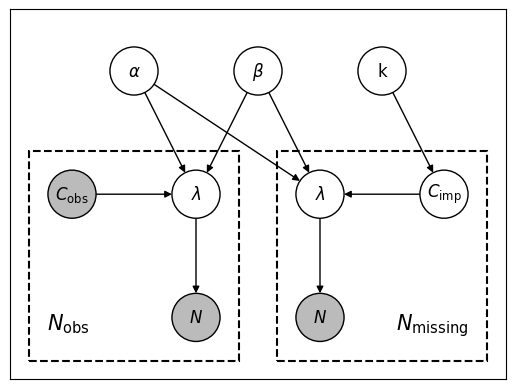

In [405]:
G = nx.DiGraph()
G.add_nodes_from([
    ("a", dict(pos=(0, 0), label=r"$\alpha$")),
    ("b", dict(pos=(1, 0), label=r"$\beta$")),
    ("k", dict(pos=(2, 0))),
    ("Cobs", dict(pos=(-0.5, -1), observed=True, label=r"$C_{\mathrm{obs}}$")),
    ("lobs", dict(pos=(0.5, -1), label=r"$\lambda$")),
    ("Nobs", dict(pos=(0.5, -2), observed=True, label=r"$N$")),
    ("Cimp", dict(pos=(2.5, -1), label=r"$C_{\mathrm{imp}}$")),
    ("limp", dict(pos=(1.5, -1), label=r"$\lambda$")),
    ("Nimp", dict(pos=(1.5, -2), observed=True, label=r"$N$"))
])
G.add_edges_from([
    ("a","lobs"), ("b","lobs"), ("Cobs","lobs"), ("lobs","Nobs"), # observed cats
    ("k","Cimp"), ("a","limp"), ("b","limp"), ("Cimp","limp"), ("limp","Nimp"), # imputed cats
])
pos = nx.get_node_attributes(G, "pos")
labels = {n: G.nodes[n].get("label", n) for n in G.nodes}
col = ["#BBBBBB" if G.nodes[n].get("observed") else "white" for n in G.nodes]
nx.draw_networkx(G, pos=pos, labels=labels, node_size=1200, node_color=col, edgecolors="black")
ax = plt.gca()
ax.add_patch(patches.Rectangle((-0.85, -2.35), 1.7, 1.7, fc="none", ec="black", lw=1.5, ls="--"))
ax.add_patch(patches.Rectangle((1.15, -2.35), 1.7, 1.7, fc="none", ec="black", lw=1.5, ls="--"))
plt.text(-0.7, -2.1, r"$N_{\mathrm{obs}}$", fontsize=15, horizontalalignment="left")
plt.text(2.7, -2.1, r"$N_{\mathrm{missing}}$", fontsize=15, horizontalalignment="right")
plt.xlim(left=-1, right=3)
plt.ylim(bottom=-2.5, top=0.5)
plt.show()

In this diagram, the (un)shaded nodes are (un)observed, and all the variables within the dashed boxes (i.e. _plates_) are repeated according to the number of times specified ($N_\mathrm{obs}$ and $N_\mathrm{missing}$, corresponding to observed and imputed cat data). Notice how the `pyro.plate` contexts below encapsulate all the distributions/variables sampled/computed within the plates in the diagram above.

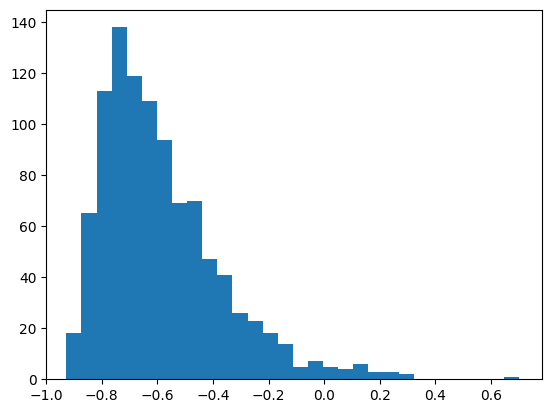

In [406]:
plt.hist(LogNormal(-1, 0.5).sample([1000])-1, bins=30)
plt.xlim(left=-1)
plt.show()

In [407]:
def model_m15_8(data, training=False):
    #a = pyro.sample("α", LogNormal(1.5, 0.5))
    #b = pyro.sample("β", LogNormal(-1., 0.5))
    a = pyro.sample("α", Normal(0., 1.0))
    b = pyro.sample("β", Normal(0., 0.5))
    k = pyro.sample("k", Beta(2., 2.))
    C, nan = [data[k] for k in ("cat", "nan")]
    with pyro.plate("obs", data["N_obs"]):
        λ = torch.exp(a*(1-C[~nan]) + b*C[~nan]) #λ = a*(1 + (b-1)*C[~nan])
        pyro.sample("N_obs", Poisson(λ), obs=data["notes"][~nan])
    with pyro.plate("imputed", data["N_missing"]):
        C = pyro.sample("C", Bernoulli(k))
        λ = torch.exp(a*(1-C) + b*C) #λ = a*(1 + (b-1)*C)
        pyro.sample("N_imp", Poisson(λ), obs=data["notes"][nan])

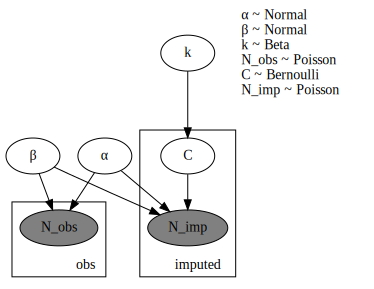

In [408]:

pyro.render_model(model_m15_8, model_args=(data, False), render_params=True, render_distributions=True, render_deterministic=True)

In [409]:
m15_8 = train_nuts(model_m15_8, data, 700, 2000, jit_compile=True)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/2700 [00:00, ?it/s]/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 2700/2700 [00:12, 218.41it/s, step size=7.63e-01, acc. prob=0.917]


In [410]:
'''
alpha = tt(5.)
beta = tt(-3.)
k = tt(0.5)
r = tt(0.2)

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      0.36      0.15      0.35      0.11      0.61   1430.16      1.00
         α      4.89      0.30      4.88      4.39      5.37   1224.77      1.00
         β      0.42      0.05      0.41      0.34      0.51   1245.18      1.00
         β	mean: -2.86	std: 0.37	median: -2.88
'''
m15_8.summary()



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         k      0.51      0.13      0.51      0.32      0.72   1583.94      1.00
         α      1.68      0.06      1.68      1.57      1.78   1922.17      1.00
         β      0.57      0.11      0.57      0.39      0.76   1379.15      1.00

Number of divergences: 0


As we can see, the posterior samples do not have $C$ in them anywhere because it has been integrated out. The posterior for $\alpha$ looks pretty close to the actual parameter, but $\beta$ looks a bit off, it was supposed to be -3. Well, look inside the model; you'll see that the `β` learned by HMC is related to the true $\beta$ by $\beta \leftarrow \alpha(\texttt{β}-1)$ (this is done to enforce positivity of $\lambda$). After performing this transformation, you'll see that it's pretty spot-on:

In [411]:
s = m15_8.get_samples()
a = torch.exp(s["α"])
b = torch.exp(s["β"])
print("α", a.mean(), "β", b.mean())

α tensor(5.3655) β tensor(1.7763)


In [412]:
'''
s = m15_8.get_samples()
b = s["α"]*(s["β"]-1)
print(f"β\tmean: {b.mean():.2f}\tstd: {b.std():.2f}\tmedian: {b.median():.2f}")
'''

'\ns = m15_8.get_samples()\nb = s["α"]*(s["β"]-1)\nprint(f"β\tmean: {b.mean():.2f}\tstd: {b.std():.2f}\tmedian: {b.median():.2f}")\n'

One of the downsides of integrating out the discrete variables is that we don't really get any idea of what the missing values might actually be. We can remedy this by simply moving the sample statement for $k$ inside the plate for the imputed data, which will generate $N_\mathrm{missing}$ $k_i$ values that will tell us the probability of a cat being at any given household. From this, we can simply generate the distribution of potential cats by sampling from $\text{Bernoulli}(k)$.

In [413]:
def model_m15_9(data, training=False):
    a = pyro.sample("α", LogNormal(1.5, 0.5))
    b = pyro.sample("β", LogNormal(-1., 0.5))
    C, nan = [data[k] for k in ("cat", "nan")]
    with pyro.plate("obs", data["N_obs"]):
        λ = a*(1 + (b-1)*C[~nan])
        pyro.sample("N_obs", Poisson(λ), obs=data["notes"][~nan])
    with pyro.plate("imputed", data["N_missing"]):
        k = pyro.sample("k", Beta(2., 2.))
        C = pyro.sample("C", Bernoulli(k))
        λ = a*(1 + (b-1)*C)
        pyro.sample("N_imp", Poisson(λ), obs=data["notes"][nan])

In [414]:
m15_9 = train_nuts(model_m15_9, data, 700, 2000, jit_compile=True)

{'adapt_step_size': True, 'adapt_mass_matrix': True, 'jit_compile': True}


Warmup:   0%|          | 0/2700 [00:00, ?it/s]/home/mb600l/conda_env/pytorch_GPU_3.9/lib/python3.9/site-packages/pyro/poutine/subsample_messenger.py:70: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  result = torch.tensor(0.0, device=self.device)
Sample: 100%|██████████| 2700/2700 [00:28, 96.43it/s, step size=4.53e-01, acc. prob=0.910] 


In [415]:
m15_9.summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      k[0]      0.41      0.20      0.39      0.07      0.71   2863.01      1.00
      k[1]      0.55      0.22      0.56      0.20      0.90   2471.37      1.00
      k[2]      0.52      0.22      0.51      0.17      0.90   2404.85      1.00
      k[3]      0.40      0.21      0.38      0.08      0.73   2071.93      1.00
      k[4]      0.56      0.22      0.57      0.22      0.92   2730.10      1.00
      k[5]      0.51      0.22      0.52      0.12      0.84   2648.34      1.00
      k[6]      0.40      0.20      0.38      0.05      0.69   1882.07      1.00
      k[7]      0.41      0.20      0.41      0.09      0.73   2182.20      1.00
      k[8]      0.56      0.21      0.58      0.24      0.91   2850.82      1.00
      k[9]      0.56      0.21      0.57      0.23      0.91   2639.91      1.00
     k[10]      0.57      0.21      0.57      0.22      0.90   3402.95      1.00
     k[11]      0.58      0

We can see the inference of $k$ is actually fairly uncertain; most values are pretty clustered around 1/2. It is difficult to tell from a single sample whether the cat is there or not because of the high variance in the Poisson process at low rates! (The Poisson variance is equal to the mean, so the ratio of the standard deviation to the mean is $\lambda^{-1/2}$, so the distribution is pretty narrow at high values of $\lambda$, but pretty broad for low values, as is the case here.)

### Code 15.24 - 15.28
We will continue to learn about missing data in the context of the "moralizing gods" dataset. In some religions, dieties enforce morals (like "thou shall not kill", etc.) on their adherents, but not always. We have the following dataset that has a bunch of info about historical religions, the evolution of their population (log scale) through time, whether they had writing or not, and whether they had moralizing gods or not.

In [416]:
gods_df = pd.read_csv("data/Moralizing_gods.csv", sep=";")
gods_df.sample(8)

,polity,year,population,moralizing_gods,writing
540,Orkhon Valley,200,6.037313,NaN,0
674,Susiana,-6600,2.485349,NaN,0
411,Latium,1700,6.278754,1.0,1
138,Kachi Plain,-6600,3.181653,NaN,0
503,Niger Inland Delta,1100,6.164650,1.0,1
667,Susiana,-7300,2.585659,NaN,0
216,Kachi Plain,1200,7.377241,1.0,1
249,Konya Plain,-9500,2.614697,NaN,0


If we look at a summary, we can see that there is a LOT of data missing about whether a society has moralizing gods or not. Often times, we simply can't tell (likely due to the lack of written records, or simply any records that have survived from ages ago) whether they had moralizing gods; they might have, but we just don't know.

In [417]:
gods_df.describe()

,year,population,moralizing_gods,writing
count,864.000000,864.000000,336.000000,864.000000
mean,-1339.351852,4.862465,0.949405,0.459491
std,2643.227871,1.763263,0.219497,0.498645
min,-9600.000000,1.408324,0.000000,0.000000
25%,-2900.000000,3.218477,1.000000,0.000000
50%,-600.000000,4.769139,1.000000,0.000000
75%,800.000000,6.418871,1.000000,1.000000
max,1900.000000,8.530465,1.000000,1.000000


The hypothesis we want to explore is whether the belief of moralizing gods helps a society prosper (since there are more reasons for citizens to collaborate or treat each other nicely). What we need is some kind of comparison of population growth rates before and after each society adopts moralizing gods (if we even have any data about that). There are likely many confounds, but let's pretend they do not exist at the moment. Therefore, if there are no confounds, the data is missing at random, and it doesn't matter if we drop it. Let's verify this with a plot of the missingness.

Warmup:   0%|          | 0/2700 [59:42, ?it/s]


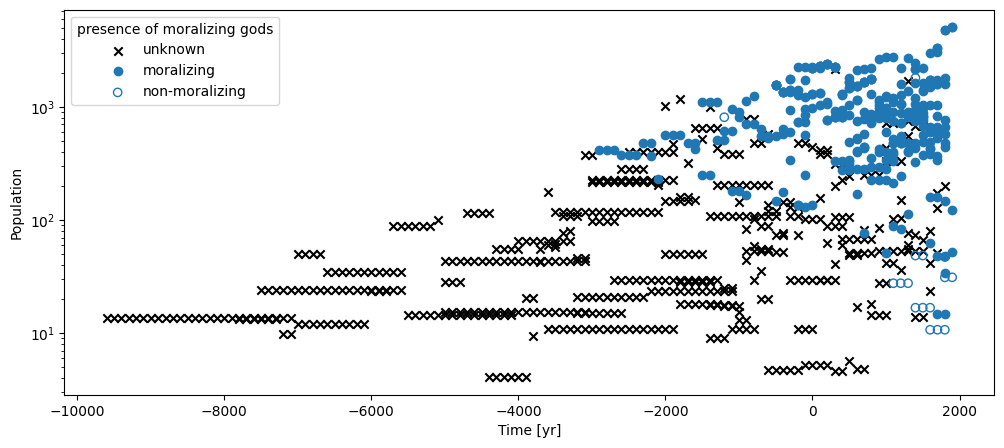

In [418]:
x = gods_df["year"].values
y = (np.e**gods_df["population"]).values
gods = gods_df["moralizing_gods"].values
plt.figure(figsize=(12, 5))
# plot missing values
mask = np.isnan(gods)
plt.scatter(x[mask], y[mask], color="black", marker="x", label="unknown")
# plot moralizing gods
mask = gods == 1
plt.scatter(x[mask], y[mask], color="C0", label="moralizing")
# plot non-moralizing gods
mask = gods == 0
plt.scatter(x[mask], y[mask], facecolor="none", edgecolor="C0", label="non-moralizing")
plt.yscale("log")
plt.xlabel("Time [yr]")
plt.ylabel("Population")
plt.legend(title="presence of moralizing gods")
plt.show()

Well, it certainly seems like the missingness is not distributed at random. There is is a strong correlation with both time and population. It seems that at earlier times, and for lower populations, the data is more likely to be missing. Let's cross-tabulate the presence of moralizing gods and literacy.

In [419]:
df = gods_df.rename(columns={"moralizing_gods": "gods", "writing": "literacy"})
df["gods"].fillna("<NA>", inplace=True)
df["literacy"].fillna("<NA>", inplace=True)
pd.crosstab(df["gods"], df["literacy"])

/tmp/ipykernel_5448/2617905776.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["gods"].fillna("<NA>", inplace=True)
/tmp/ipykernel_5448/2617905776.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<NA>' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df["gods"].fillna("<NA>", inplace=True)
/tmp/ipykernel_5448/2617905776.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame o

literacy,0,1
gods,,
0.0,16,1
1.0,9,310
<NA>,442,86


Societies without literacy are very unlikely to have written records of _any_ kind, let alone whether their gods were moralizing or not. It seems that there is so much missingness, and it is so highly correlated with the other variables, that it is very unlikely we will be able to answer our question. Let's draw out an optimistic caual DAG that really hits this home.

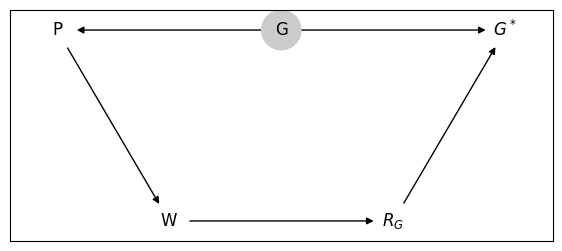

In [420]:
G = nx.DiGraph()
G.add_nodes_from([
    ("P", dict(pos=(0, 1), color="white")),
    ("G", dict(pos=(1, 1), color="#CCCCCC")),
    ("G*", dict(pos=(2, 1), color="white", label=r"$G^*$")),
    ("W", dict(pos=(0.5, 0), color="white")),
    ("RG", dict(pos=(1.5, 0), color="white", label=r"$R_G$")),
])
G.add_edges_from([("G","P"),("P","W"),("W","RG"),("RG","G*"),("G","G*")])
plt.figure(figsize=(7, 3))
plot_graph(G)

In this scenario, the presence of moralizing gods $G$ influences population growth $P$ (not the same thing as the population variable), which in turn influences writing $W$, the absence of which causes data on gods $G^*$ to go missing through $R_G$. The goal here is to determine whether the outcome $P$ is independent of missingness $R_G$. We can see that $P \perp\!\!\perp R_G | W$, so in principle, yes, we can determine whether $P$ and $R_G$ are independent by conditioning on $W$. However, if they are NOT independent, then conditioning on $W$ blocks the causal path $P \rightarrow W \rightarrow R_G$, and so now we can't estimate how much $P$ influences $R_G$, because the other path through $P \leftarrow G \rightarrow G^* \leftarrow R_G$ is non-causal. (although it doesn't necessarily bias inference as long as we don't condition on $G^*$ (i.e. throw away missing data - hence the danger).

Our last hope is to condition on $G$ itself. But this will require imputation of the data, and with so much missing data, it will be difficult to create a model for how $G$ is generated. Just take a look at the data for Hawaii, which by the time Europeans (James Cook) made contact in 1778, was a thriving population with moralizing gods, but no writing.

In [421]:
gods_df[gods_df["polity"]=="Big Island Hawaii"][["year","population","writing","moralizing_gods"]].T

,0,1,2,3,4,5,6,7,8
year,1000.000000,1100.000000,1200.00000,1300.00000,1400.000000,1500.000000,1600.00000,1700.000000,1800.000000
population,3.729643,3.729643,3.59834,4.02624,4.311767,4.205113,4.37396,5.157593,4.997439
writing,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000
moralizing_gods,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000


Obviously the Hawaiians didn't just suddenly develop religion and moralizing gods when the Europeans arrived. There is not a clear method for generating these values. We don't have a model-based way imputate, nor is it a good idea to base our imputation off population, because that is the very relationship in question. We are also limited by the fact that the moralizing gods variable is discrete, not continuous, which presents its own difficulties when being modeled as a latent.